In [1]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from pathlib import Path
from tkinter import filedialog
import seaborn as sns
import itertools
from colour import Color
from datetime import date
import tifffile
import scipy  as spy
from skimage import filters

In [2]:
today = date.today()
print("Today's date:", today)
date_today = str(today)
date_today

Today's date: 2022-05-16


'2022-05-16'

In [3]:
askfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
filepath = Path(askfile)
filename = filepath.stem
filepath, filename

(WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel/20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1.tif'),
 '20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1')

# Checking image #

In [4]:
raw = tifffile.imread(filepath)

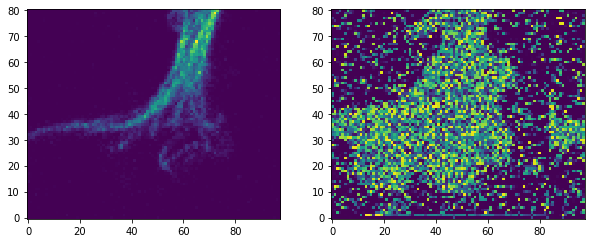

In [5]:
fig, ax = plt.subplots(1,2,figsize=(10,10))

ax[0].imshow(raw[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1].imshow(raw[1], interpolation='none', origin=[0, 0], cmap='viridis')

## Metadata ##

In [18]:
CH1 = 'Microtubules'
CH2 = 'Actin'
Type = 'Type'

In [19]:
def acquire_metadata(filepath):

    dates = []
    neuron_type = []
    
    i= filepath
    
    filename = i.stem
    
    #get the file metadata
    neuron_type_start = str(i).find(' A ')
    neuron_type_end = str(i).find(' Ext', neuron_type_start)
    neuron_type = neuron_type + [(str(i)[neuron_type_start+3:neuron_type_end])]

    dateloc = str(i).rfind("202")   
    dates = dates + [str(i)[dateloc : dateloc+8]]     
        
    pre_df = {'Filename': filename,'Date': dates, Type:neuron_type}
    df = pd.DataFrame(pre_df) 
    
    return df
    

In [20]:
metadata = acquire_metadata(filepath)
metadata

,Filename,Date,Type
0,20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3...,20210419,Ctrl Y


## Otsu mask ##

In [21]:
BColoc = 'Binary Colocalization'
PCorr = 'Pearson Correlation'
PPVal = 'Pearson P-Value'

In [22]:
def make_mask(image,median_size,mask_size): #image is single channel of stack
    
    #median filter (optional)
    median_mask = spy.ndimage.median_filter(image, size=median_size)
    
    #otsu filter
    otsu_marker = filters.threshold_otsu(median_mask)
    im_otsu = image > otsu_marker

    #size filter (optional)
    label_objects, nb_labels = spy.ndimage.label(im_otsu)
    
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > mask_size
    mask_sizes[0] = 0

    im_binary = mask_sizes[label_objects]
    
    #convert to image type array
    im_binary = im_binary.astype(np.uint16)
    
    im_masked = image * im_binary
    
    return im_masked,im_binary

In [31]:
def colocalization_processing(filepath,metadata, mask_size, median_size):
    
    Bcoloc = []
    Pcorr = []
    Ppval = []
    
    #make results folder
    resultdirectory = str(filepath.parents[0])+'//results'
    resultdir = Path(resultdirectory)
    resultdir.mkdir(exist_ok=True)

    i = filepath
    
    #Process Otsu masks of each channel
    im_CH1,im_CH2 = tifffile.imread(i)

    im_CH1_masked,im_CH1_binary = make_mask(im_CH1,median_size,mask_size)

    im_CH2_masked,im_CH2_binary = make_mask(im_CH2,median_size,mask_size)


    #Calculate binary colocalization
    coloc0 = np.sum(im_CH2_binary)/np.sum(im_CH1_binary) #actin/mts
    Bcoloc = Bcoloc + [coloc0]

    #Calculate pearson correlation
    coefficient0, pval0 = spy.stats.pearsonr(im_CH1_masked.flatten(), im_CH2_masked.flatten())
    Pcorr = Pcorr + [coefficient0]
    Ppval = Ppval + [pval0]

    #Make stack from processed channels
    im_binary = np.append([im_CH1_binary], [im_CH2_binary],axis=0)
    im_masked = np.append([im_CH1_masked], [im_CH2_masked],axis=0)

    #Save processed images
    filename = i.stem
    tifffile.imsave(resultdir/(filename+'_binary.tif'), im_binary)
    tifffile.imsave(resultdir/(filename+'_masked.tif'), im_masked)
        
    #Input results into dataframe
    results = metadata
    results[BColoc] = Bcoloc
    results[PCorr] = Pcorr
    results[PPVal] = Ppval
    results['Mask Size'] = mask_size
    results['Median Size'] = median_size
    
    
    return results,resultdir
    

In [32]:
mask_size = 0
median_size = 1
results,resultdir = colocalization_processing(filepath,metadata,mask_size,median_size)

In [33]:
results

,Filename,Date,Type,Binary Colocalization,Pearson Correlation,Pearson P-Value,Mask Size,Median Size
0,20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3...,20210419,Ctrl Y,4.783929,0.039344,0.000455,0,1


In [38]:
newdirectory = str(filepath.parents[1])+'//Colocalization-Correlation_Data_Sheets'
newmydir = Path(newdirectory)
newmydir.mkdir(exist_ok=True)

In [39]:
results.to_csv(filepath.parents[0]/(date_today+'_'+ filename +'_Colocalization-Correlation.csv'), encoding='utf-8', index=False)
results.to_csv(newmydir/(date_today+'_'+ filename +'_Colocalization-Correlation.csv'), encoding='utf-8', index=False)

## Visualize Processed Images ##

In [159]:
askfile = filedialog.askopenfilename() # show an "Open" dialog box and return the path to the folder on ONE date you want to process
filepath = Path(askfile)
filename = filepath.stem
filepath, filename

(WindowsPath('C:/Users/sofia/OneDrive/Documentos/mcgill/brouhardlab/labmates/Muriel/20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1.tif'),
 '20210419 hiNeurons A Ctrl Y Ext-PFA DIV3 Tubb3-A488 Phalloidin-A568 DCX(gt)-A647 DAPI z1.0 63x001-4-1')

In [168]:
raw = tifffile.imread(filepath)
im_binary = tifffile.imread(resultdir/(filename+'_binary.tif'))
im_masked = tifffile.imread(resultdir/(filename+'_masked.tif'))

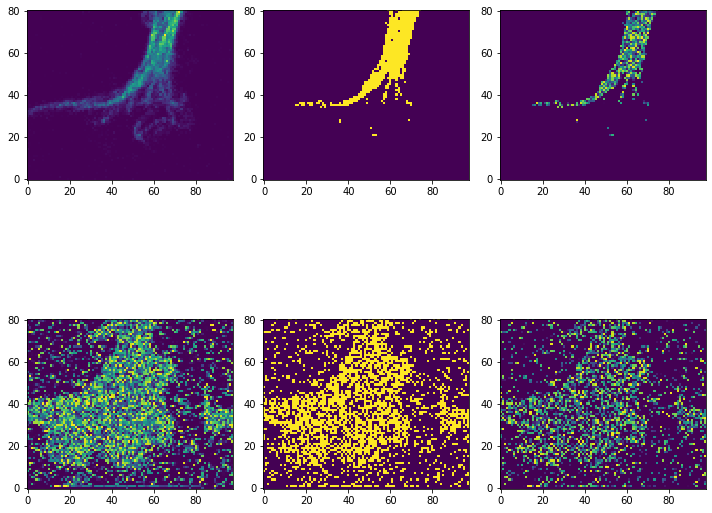

In [169]:
fig, ax = plt.subplots(2,3,figsize=(10,10))

ax[0,0].imshow(raw[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,0].imshow(raw[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,1].imshow(im_binary[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,1].imshow(im_binary[1], interpolation='none', origin=[0, 0], cmap='viridis')
ax[0,2].imshow(im_masked[0], interpolation='none', origin=[0, 0], cmap='viridis')
ax[1,2].imshow(im_masked[1], interpolation='none', origin=[0, 0], cmap='viridis')

plt.tight_layout()